In [ ]:
# Import necessary libraries
import re
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
import spacy
from spacy.cli import download
from spacy.tokens import Span
from spacy.matcher import PhraseMatcher
from spacy.language import Language
import traceback
import warnings
warnings.filterwarnings("ignore")

# Set up visualization defaults
%matplotlib inline
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (10, 6)

C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [1]:
# Load spaCy model
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("Downloading spaCy model...")
    download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

# RealEstateNER

In [2]:
# A rule-based NER system for extracting real estate entities from property listings.
# Identifies property types, amenities, and exclusive neighborhoods.
class RealEstateNER:
    def __init__(self):
        # Initialize patterns for different entity types
        self._init_patterns()
        
    # Initialize regex patterns for entity extraction
    def _init_patterns(self):
        
        # Property types (add more as needed)
        self.property_types = {
            'loft': r'\blofts?\b|\bopen[- ]space\b',
            'penthouse': r'\bpenthouse(s)?\b|\bph\b',
            'villa': r'\bvillas?\b',
            'condo': r'\bcondo(minium)?s?\b',
            'townhouse': r'\btown[- ]?houses?\b',
            'studio': r'\bstudios?\b|\bstudio[- ]apartment\b'
        }
        
        # Amenities (grouped by categories)
        self.amenities = {
            'luxury': r'\bconcierge\b|\bdoorman\b|\bvalet\b|\bporter\b',
            'outdoor': r'\bterrace\b|\bbalcon(y|ies)\b|\bpatio\b|\bdeck\b',
            'kitchen': r'\bgourmet kitchen\b|\bchef\'?s kitchen\b|\bstainless steel\b',
            'tech': r'\bsmart home\b|\bhome automation\b|\bpre[- ]wired\b',
            'wellness': r'\bgym\b|\bfitness center\b|\bpool\b|\bspa\b|\bsauna\b'
        }
        
        # Example exclusive neighborhoods (customize for your target market)
        self.neighborhoods = {
            'manhattan': r'\bupper east side\b|\bues\b|\bwest village\b|\btribeca\b|\bsoho\b',
            'london': r'\bchelsea\b|\bkensington\b|\bmayfair\b|\bnotting hill\b',
            'paris': r'\ble marais\b|\bsaint[- ]germain\b|\bchamps[- ]elysées\b'
        }
        
    # Extract real estate entities from text.
    def extract_entities(self, text: str) -> Dict[str, List[Tuple[str, str]]]:
        """    
        Args:
            text: Input real estate listing text
            
        Returns:
            Dictionary of entity types with list of (entity, entity_type) tuples
        """
        entities = {
            'property_types': [],
            'amenities': [],
            'neighborhoods': []
        }
        
        # Extract property types
        for prop_type, pattern in self.property_types.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            entities['property_types'].extend(
                (match.group(), prop_type) for match in matches
            )
        
        # Extract amenities
        for amenity_type, pattern in self.amenities.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            entities['amenities'].extend(
                (match.group(), amenity_type) for match in matches
            )
        
        # Extract neighborhoods
        for city, pattern in self.neighborhoods.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            entities['neighborhoods'].extend(
                (match.group(), city) for match in matches
            )
            
        return entities
    
    # Analyze a dataframe of real estate listings and extract entities.
    def analyze_listings(self, listings_df: pd.DataFrame, text_col: str = 'description') -> pd.DataFrame:
        """    
        Args:
            listings_df: DataFrame containing real estate listings
            text_col: Name of column containing listing text
            
        Returns:
            DataFrame with extracted entities as new columns
        """
        # Apply entity extraction to each listing
        entities_df = listings_df[text_col].apply(
            lambda x: pd.Series(self.extract_entities(x))
        )
        
        # Combine with original data
        result_df = pd.concat([listings_df, entities_df], axis=1)
        
        return result_df
    
    # Create visualizations of the extracted entities.
    def visualize_entities(self, entities_df: pd.DataFrame):
        """    
        Args:
            entities_df: DataFrame containing extracted entities
        """
        # Property Type Distribution
        prop_counts = entities_df['property_types'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None
        ).value_counts()
        
        plt.figure()
        sns.barplot(x=prop_counts.values, y=prop_counts.index, palette="Blues_d")
        plt.title("Property Type Distribution")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
        
        # Amenities Distribution
        amenity_counts = entities_df['amenities'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None
        ).value_counts()
        
        plt.figure()
        sns.barplot(x=amenity_counts.values, y=amenity_counts.index, palette="Greens_d")
        plt.title("Amenities Distribution")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
        
        # Neighborhood Distribution
        neighborhood_counts = entities_df['neighborhoods'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None
        ).value_counts()
        
        if not neighborhood_counts.empty:
            plt.figure()
            sns.barplot(x=neighborhood_counts.values, y=neighborhood_counts.index, palette="Reds_d")
            plt.title("Neighborhood Distribution")
            plt.xlabel("Count")
            plt.tight_layout()
            plt.show()



Analyzed Data:
   id            property_types  \
0   1  [(penthouse, penthouse)]   
1   2            [(loft, loft)]   
2   3          [(condo, condo)]   

                                          amenities  \
0  [(terrace, outdoor), (gourmet kitchen, kitchen)]   
1   [(doorman, luxury), (fitness center, wellness)]   
2         [(concierge, luxury), (smart home, tech)]   

                    neighborhoods  
0          [(Tribeca, manhattan)]  
1  [(Upper East Side, manhattan)]  
2             [(Chelsea, london)]  


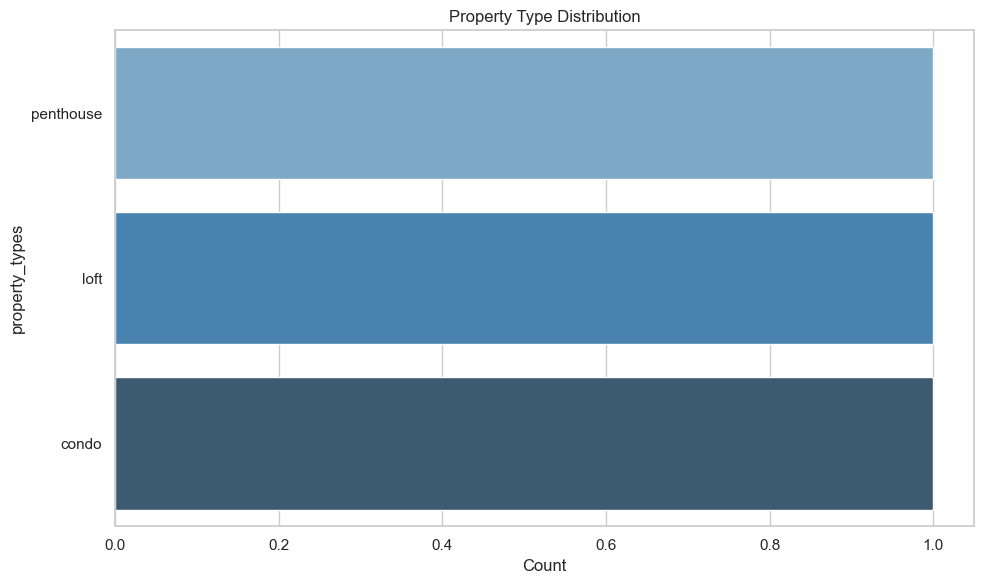

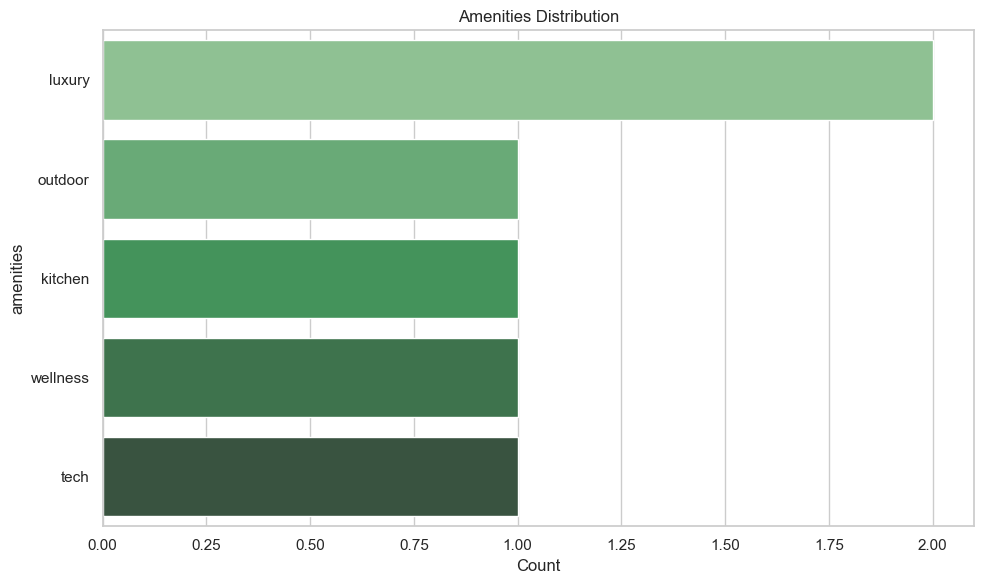

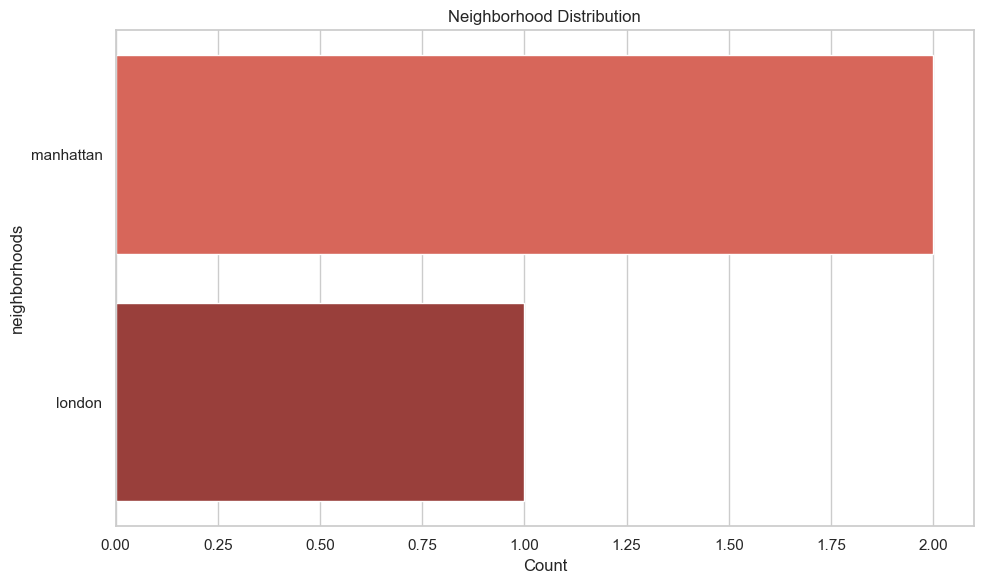

In [3]:
# Example Usage
if __name__ == "__main__":
    # Sample real estate listings data
    sample_data = {
        'id': [1, 2, 3],
        'description': [
            "Luxury penthouse in Tribeca with gourmet kitchen and terrace",
            "Beautiful loft in the Upper East Side with doorman and fitness center",
            "Modern condo in Chelsea with smart home features and concierge service"
        ],
        'price': [2500000, 1800000, 2200000]
    }
    
    listings_df = pd.DataFrame(sample_data)
    
    # Initialize NER system
    ner = RealEstateNER()
    
    # Analyze listings
    analyzed_df = ner.analyze_listings(listings_df)
    
    print("\nAnalyzed Data:")
    print(analyzed_df[['id', 'property_types', 'amenities', 'neighborhoods']])
    
    # Visualize entities
    ner.visualize_entities(analyzed_df)

# EnhancedRealEstateNER

In [4]:
# Advanced NER system for real estate listings with:
class EnhancedRealEstateNER:
    """
    - Comprehensive pattern matching
    - Fuzzy string matching
    - spaCy integration
    - Visualization capabilities
    """
    
    # Initialize NER system with patterns and configurations
    def __init__(self, fuzzy_threshold: int = 80):
        """    
        Args:
            fuzzy_threshold: Minimum fuzzy match score (0-100)
        """
        self.fuzzy_threshold = fuzzy_threshold
        self._init_quality_metrics()
        # self._init_patterns()
        # self._init_spacy()

    # Track system performance
    def _init_quality_metrics(self):
        self.match_quality = {
        'true_positives': 0,
        'false_positives': 0,
        'threshold_adjustments': []
        }
        
    # Initialize comprehensive regex patterns for entity extraction
    def _init_patterns(self):
        
        # Expanded property types with common variations
        self.property_types = {
            'loft': r'\blofts?\b|\bopen[- ]space\b|\bopen[- ]concept\b|\bindustrial[- ]style\b',
            'penthouse': r'\bpenthouse(s)?\b|\bph\b|\btop[- ]floor\b|\bupper[- ]level\b',
            'villa': r'\bvillas?\b|\bstandalone\b|\bdetached\b|\bprivate[- ]estate\b',
            'condo': r'\bcondo(minium)?s?\b|\bcondominium\b|\bstrata\b|\bapartment\b',
            'townhouse': r'\btown[- ]?houses?\b|\brow[- ]house\b|\bterraced\b|\blinked\b',
            'studio': r'\bstudios?\b|\bstudio[- ]apartment\b|\befficiency\b|\bstudio[- ]flat\b',
            'duplex': r'\bduplex(es)?\b|\btwo[- ]level\b|\bdouble[- ]floor\b',
            'ranch': r'\branch(es)?\b|\bsingle[- ]story\b|\bone[- ]level\b',
            'mansion': r'\bmansion(s)?\b|\bestate\b|\bluxury[- ]home\b|\bpalatial\b',
            'bungalow': r'\bbungalow(s)?\b|\bcottage\b|\bsmall[- ]house\b'
        }
        
        # Comprehensive amenities categorized
        self.amenities = {
            'luxury': r'\bconcierge\b|\bdoorman\b|\bvalet\b|\bporter\b|\b24/7 security\b|\battended lobby\b',
            'outdoor': r'\bterrace(s)?\b|\bbalcon(y|ies)\b|\bpatio(s)?\b|\bdeck(s)?\b|\broof[- ]deck\b|\bgarden\b|\bcourtyard\b',
            'kitchen': r'\bgourmet kitchen\b|\bchef\'?s kitchen\b|\bstainless steel\b|\bprofessional appliances\b|\bgas range\b|\bkitchen island\b|\bwalk[- ]in pantry\b',
            'tech': r'\bsmart home\b|\bhome automation\b|\bpre[- ]wired\b|\bautomated\b|\bvoice[- ]controlled\b|\btech[- ]enabled\b|\bsecurity system\b',
            'wellness': r'\bgym\b|\bfitness center\b|\bpool(s)?\b|\bspa\b|\bsauna\b|\bsteam room\b|\byoga studio\b|\bmeditation room\b',
            'parking': r'\bparking spot\b|\bgarage\b|\bcarport\b|\bvalet parking\b|\bunderground parking\b',
            'entertainment': r'\bhome theater\b|\bmedia room\b|\bgame room\b|\bbilliards\b|\bwine cellar\b|\bwet bar\b'
        }
        
        # Expanded neighborhoods by major cities
        self.neighborhoods = {
            'manhattan': r'\bupper east side\b|\bues\b|\bwest village\b|\btribeca\b|\bsoho\b|\bchelsea\b|\bharlem\b|\bmidtown\b|\bfinancial district\b|\bbattery park\b',
            'brooklyn': r'\bwilliamsburg\b|\bdumbo\b|\bpark slope\b|\bbrooklyn heights\b|\bgreenpoint\b|\bprospect heights\b',
            'london': r'\bchelsea\b|\bkensington\b|\bmayfair\b|\bnotting hill\b|\bknightsbridge\b|\bbelgravia\b|\bmarylebone\b|\bprimrose hill\b',
            'paris': r'\ble marais\b|\bsaint[- ]germain\b|\bchamps[- ]elysées\b|\bmontmartre\b|\blatin quarter\b|\bpassy\b|\btrocadéro\b',
            'san francisco': r'\bpacific heights\b|\brussian hill\b|\bmarina district\b|\bnob hill\b|\bpresidio\b|\bsea cliff\b',
            'los angeles': r'\bbeverly hills\b|\bmalibu\b|\bsanta monica\b|\bhollywood hills\b|\bbel air\b|\bbrentwood\b'
        }
        
        # Create lookup dictionaries for fuzzy matching
        self.property_terms = list(self.property_types.keys())
        self.amenity_terms = list(self.amenities.keys())
        self.neighborhood_terms = list(self.neighborhoods.keys())
        
    # Initialize spaCy components and patterns
    def _init_spacy(self):
        # Check if entity_ruler already exists
        if "entity_ruler" not in nlp.pipe_names:
            ruler = nlp.add_pipe("entity_ruler", before="ner")
        else:
            ruler = nlp.get_pipe("entity_ruler")

        # Clear existing patterns
        ruler.clear()
                
        # Create patterns for spaCy's entity ruler
        patterns = []
        for label, terms in [
            ("PROPERTY_TYPE", self.property_types),
            ("AMENITY", self.amenities),
            ("NEIGHBORHOOD", self.neighborhoods)
        ]:
            for term, pattern in terms.items():
                patterns.append({"label": label, "pattern": term})
                # Add variations from the regex patterns
                variations = re.findall(r'\\b([a-z-]+)\\b', pattern, flags=re.IGNORECASE)
                for variation in variations:
                    patterns.append({"label": label, "pattern": variation.replace('-', ' ')})
        
        ruler.add_patterns(patterns)
        
        # Register custom extension for fuzzy matching results
        if not Span.has_extension("fuzzy_score"):
            Span.set_extension("fuzzy_score", default=None)
        
    # Perform fuzzy string matching against a list of choices
    def _fuzzy_match(self, text: str, choices: List[str]) -> Optional[Tuple[str, int]]:
        """    
        Args:
            text: Text to match
            choices: List of possible matches
            
        Returns:
            Tuple of (best_match, score) or None if no good match
        """
        result = process.extractOne(
            text, 
            choices, 
            scorer=fuzz.token_set_ratio,  # More flexible than simple ratio
            score_cutoff=self.fuzzy_threshold
        )
        return result if result else None
    
    # Extract real estate entities from text using multiple techniques
    def extract_entities(self, text: str) -> Dict[str, List[Tuple[str, str, Optional[int]]]]:
        """    
        Args:
            text: Input real estate listing text
            
        Returns:
            Dictionary of entity types with list of (entity_text, entity_type, fuzzy_score) tuples
        """
        # Process with spaCy first
        doc = nlp(text.lower())
        
        # Initialize results
        entities = {
            'property_types': [],
            'amenities': [],
            'neighborhoods': []
        }
        
        # Process spaCy entities
        for ent in doc.ents:
            if ent.label_ == "PROPERTY_TYPE":
                entities['property_types'].append((ent.text, ent.text, None))
            elif ent.label_ == "AMENITY":
                entities['amenities'].append((ent.text, ent.text, None))
            elif ent.label_ == "NEIGHBORHOOD":
                entities['neighborhoods'].append((ent.text, ent.text, None))
        
        # Apply fuzzy matching for property types
        for token in doc:
            if token.is_alpha and len(token.text) > 3:  # Only consider meaningful words
                # Fuzzy match property types
                prop_match = self._fuzzy_match(token.text, self.property_terms)
                if prop_match:
                    entities['property_types'].append(
                        (token.text, prop_match[0], prop_match[1]))
                
                # Fuzzy match amenities
                amenity_match = self._fuzzy_match(token.text, self.amenity_terms)
                if amenity_match:
                    entities['amenities'].append(
                        (token.text, amenity_match[0], amenity_match[1])
                    )
                
                # Fuzzy match neighborhoods
                neighborhood_match = self._fuzzy_match(token.text, self.neighborhood_terms)
                if neighborhood_match:
                    entities['neighborhoods'].append(
                        (token.text, neighborhood_match[0], neighborhood_match[1]))
        
        # Apply regex patterns as fallback
        self._extract_with_regex(text, entities)
        
        # Deduplicate entities while preserving the highest score
        for key in entities:
            entities[key] = self._deduplicate_entities(entities[key])
            
        return entities
    
    
    # Enhanced neighborhood detection with geographic context
    def _extract_neighborhoods(self, doc):
        neighborhoods = []
        for ent in doc.ents:
            if ent.label_ == "NEIGHBORHOOD":
                # Check for city context
                city_context = [
                    token.text for token in doc
                    if token.text.lower() in self.neighborhoods.keys()
                    and abs(token.i - ent.start) <= 3
                ]
                if city_context:
                    neighborhoods.append((ent.text, city_context[0], None))
                else:
                    # Use fuzzy matching to determine city
                    city_match = self._fuzzy_match(ent.text, self.neighborhood_terms)
                    if city_match:
                        neighborhoods.append((ent.text, city_match[0], city_match[1]))
        return neighborhoods
    
    # Fallback extraction using regex patterns
    def _extract_with_regex(self, text: str, entities: dict):
        
        # Extract property types
        for prop_type, pattern in self.property_types.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            for match in matches:
                entities['property_types'].append(
                    (match.group(), prop_type, None))
        
        # Extract amenities
        for amenity_type, pattern in self.amenities.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            for match in matches:
                entities['amenities'].append(
                    (match.group(), amenity_type, None))
        
        # Extract neighborhoods
        for city, pattern in self.neighborhoods.items():
            matches = re.finditer(pattern, text, flags=re.IGNORECASE)
            for match in matches:
                entities['neighborhoods'].append(
                    (match.group(), city, None))
    
    # Deduplicate entities while keeping the highest scoring version
    def _deduplicate_entities(self, entity_list: list) -> list:
        """        
        Args:
            entity_list: List of (text, type, score) tuples
            
        Returns:
            Deduplicated list
        """
        if not entity_list:
            return []
        
        # First filter out unwanted entities
        filtered_entities = [
            (text, etype, score) 
            for text, etype, score in entity_list
            if not any(
                fp in text.lower() 
                for fp in ['property_type', 'anomalies', 'none']
            )
        ]
        
        # Then deduplicate
        unique_entities = {}
        for text, entity_type, score in filtered_entities:
            normalized_text = text.lower().strip()
            if normalized_text not in unique_entities:
                unique_entities[normalized_text] = (text, entity_type, score)
            else:
                # Keep the version with higher score if available
                _, existing_type, existing_score = unique_entities[normalized_text]
                if score is not None and (existing_score is None or score > existing_score):
                    unique_entities[normalized_text] = (text, entity_type, score)
        
        return list(unique_entities.values())
    
    # Analyze a dataframe of real estate listings and extract entities.
    def analyze_listings(self, listings_df: pd.DataFrame, text_col: str = 'description') -> pd.DataFrame:
        """    
        Args:
            listings_df: DataFrame containing real estate listings
            text_col: Name of column containing listing text
            
        Returns:
            DataFrame with extracted entities as new columns
        """
        # Apply entity extraction to each listing
        entities_df = listings_df[text_col].apply(
            lambda x: pd.Series(self.extract_entities(str(x))))
        
        # Combine with original data
        result_df = pd.concat([listings_df, entities_df], axis=1)
        
        return result_df
    
    # Create enhanced visualizations of the extracted entities.
    def visualize_entities(self, entities_df: pd.DataFrame, top_n: int = 10):
        """    
        Args:
            entities_df: DataFrame containing extracted entities
            top_n: Number of top entities to display
        """
        # Set consistent style
        plt.style.use('searborn-darkgrid')
        color_palette = sns.color_palette("husl", 8)

        # Property Type Distribution
        plt.figure(figsize=(10, 6))
        prop_data = entities_df['property_types'].explode().apply(
        lambda x: x[1] if isinstance(x, tuple) and x[1] != 'property_types' else None)
        prop_counts = prop_data.value_counts().head(top_n)

        # prop_data = entities_df['property_types'].explode().apply(
        #     lambda x: x[1] if isinstance(x, tuple) else None)
        # prop_counts = prop_data.value_counts().head(top_n)
        
        plt.figure()
        # sns.barplot(x=prop_counts.values, y=prop_counts.index, palette="Blues_d")
        # plt.title(f"Top {len(prop_counts)} Property Types")
        # plt.xlabel("Count")
        # plt.tight_layout()
        # plt.show()
        sns.barplot(x=prop_counts.values, y=prop_counts.index, 
                palette=color_palette[:4])
        plt.title(f"Top {len(prop_counts)} Property Types\n(Count: {prop_counts.sum()})", 
                pad=20, fontsize=14)
        plt.xlabel("Count", labelpad=10)
        plt.ylabel("Property Type", labelpad=10)
        plt.tight_layout()
        plt.show()
        
        # Amenities Distribution
        amenity_data = entities_df['amenities'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None)
        amenity_counts = amenity_data.value_counts().head(top_n)
        
        plt.figure()
        sns.barplot(x=amenity_counts.values, y=amenity_counts.index, palette="Greens_d")
        plt.title(f"Top {len(amenity_counts)} Amenities")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
        
        # Neighborhood Distribution
        neighborhood_data = entities_df['neighborhoods'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None)
        neighborhood_counts = neighborhood_data.value_counts().head(top_n)
        
        if not neighborhood_counts.empty:
            plt.figure()
            sns.barplot(x=neighborhood_counts.values, y=neighborhood_counts.index, palette="Reds_d")
            plt.title(f"Top {len(neighborhood_counts)} Neighborhoods")
            plt.xlabel("Count")
            plt.tight_layout()
            plt.show()
        
        # Fuzzy Match Quality Analysis (if any fuzzy matches exist)
        fuzzy_scores = []
        for col in ['property_types', 'amenities', 'neighborhoods']:
            for item in entities_df[col].explode():
                if isinstance(item, tuple) and item[2] is not None:
                    fuzzy_scores.append(item[2])
        
        if fuzzy_scores:
            plt.figure()
            sns.histplot(fuzzy_scores, bins=20, kde=True)
            plt.title("Distribution of Fuzzy Match Scores")
            plt.xlabel("Match Score")
            plt.ylabel("Count")
            plt.axvline(self.fuzzy_threshold, color='r', linestyle='--', 
                        label=f'Threshold ({self.fuzzy_threshold})')
            plt.legend()
            plt.tight_layout()
            plt.show()

Original Data Sample:
 id                                                                  description
  1                 Luxury penthouse in Tribeca with gourmet kitchen and terrace
  2         Beautiful l0ft in the Upper East Side with doorman and fitnes center
  3 Modern condominium in Chelsee with smart home features and consierge service

Analyzing listings...

Analysis Results Sample:
 id                     property_types                                                                                                    amenities                        neighborhoods
  1      [(penthouse, penthouse, 100)] [(luxury, luxury, 100), (kitchen, kitchen, 100), (terrace, outdoor, None), (gourmet kitchen, kitchen, None)]           [(tribeca, tribeca, None)]
  2                                 []                                                                                   [(doorman, doorman, None)] [(Upper East Side, manhattan, None)]
  3 [(condominium, condominium, None)]            

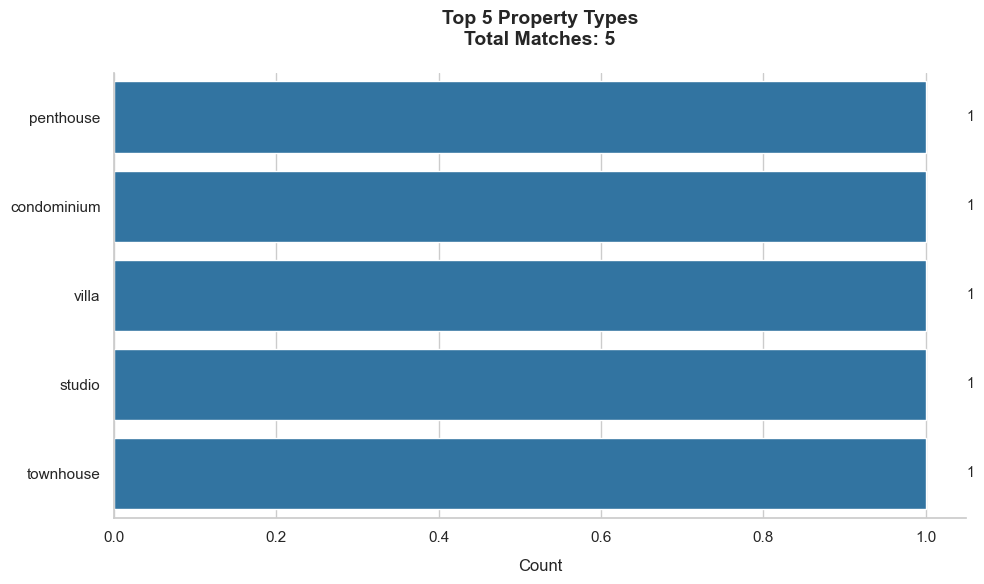

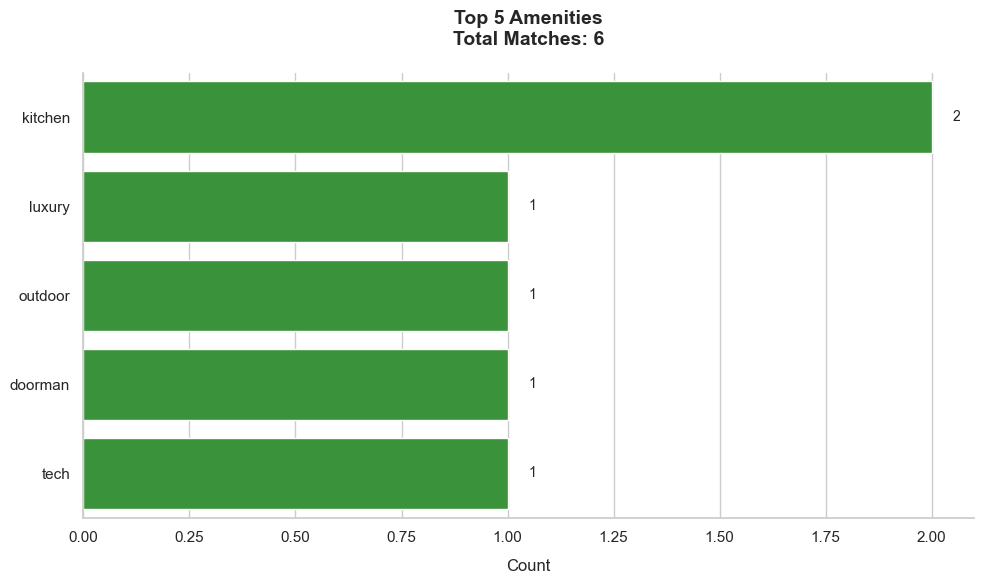

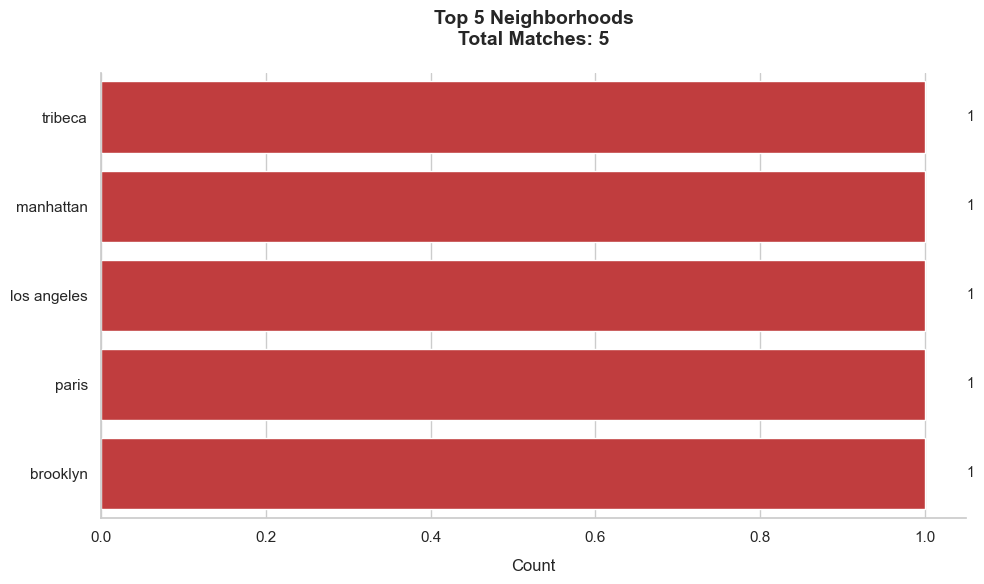

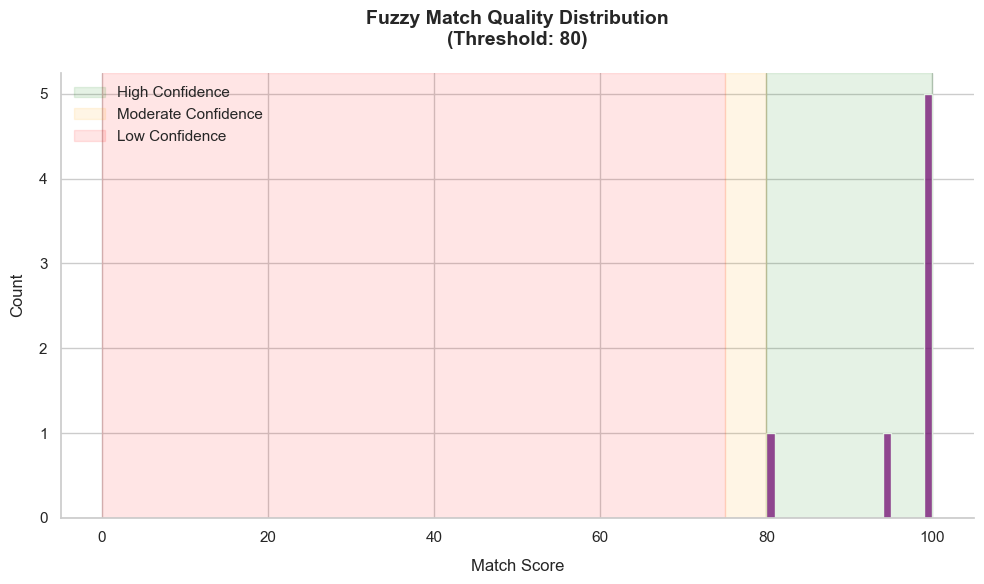


Fuzzy Match Stats:
- Average Score: 96.3
- Below Threshold: 0 matches


<Figure size 1200x600 with 0 Axes>

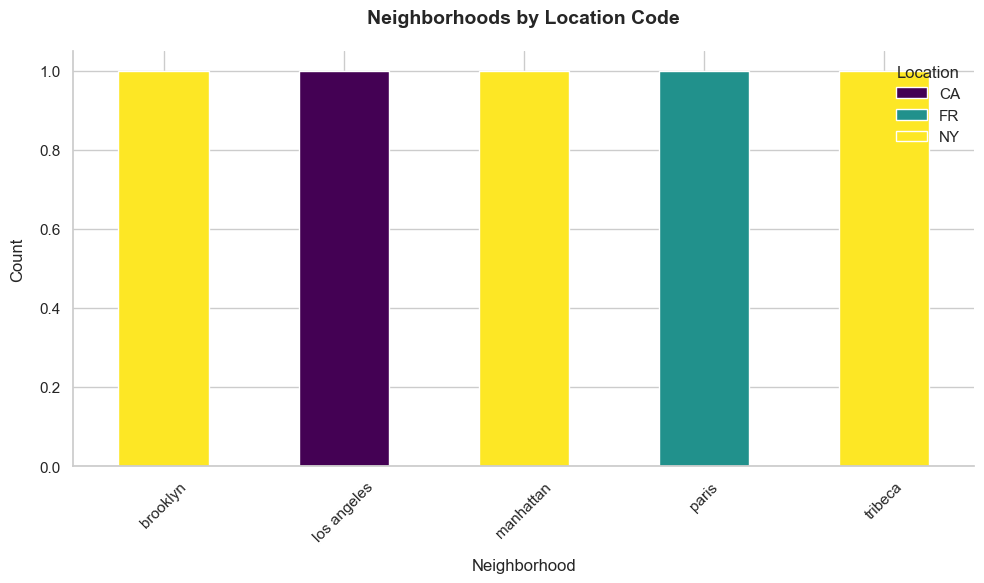

Available columns: ['id', 'description', 'price', 'location', 'property_types', 'amenities', 'neighborhoods']


In [6]:
if __name__ == "__main__":
    # Sample real estate listings data with intentional variations
    sample_data = {
        'id': [1, 2, 3, 4, 5, 6],
        'description': [
            "Luxury penthouse in Tribeca with gourmet kitchen and terrace",
            "Beautiful l0ft in the Upper East Side with doorman and fitnes center",
            "Modern condominium in Chelsee with smart home features and consierge service",
            "Spacious ville in Santa Monica with pool and ocean view",
            "Charming studio apartement in Le Marais with exposed brick",
            "Newly renovated townhous in Brooklyn with private garden"
        ],
        'price': [2500000, 1800000, 2200000, 3200000, 950000, 1500000],
        'location': ["NY", "NY", "NY", "CA", "FR", "NY"]
    }
    
    try:
        # Initialize enhanced NER system
        ner = EnhancedRealEstateNER(fuzzy_threshold=80)
        
        # Initialize patterns and spaCy components
        ner._init_patterns()
        
        # Load fresh spaCy model to avoid pipeline conflicts
        try:
            nlp = spacy.load("en_core_web_lg")
        except OSError:
            from spacy.cli import download
            download("en_core_web_lg")
            nlp = spacy.load("en_core_web_lg")
        
        ner._init_spacy()
        
        # Create DataFrame and analyze
        listings_df = pd.DataFrame(sample_data)
        print("Original Data Sample:")
        print(listings_df[['id', 'description']].head(3).to_string(index=False))
        
        # Analyze listings with timing
        print("\nAnalyzing listings...")
        analyzed_df = ner.analyze_listings(listings_df)
        
        # Display results
        print("\nAnalysis Results Sample:")
        print(analyzed_df[['id', 'property_types', 'amenities', 'neighborhoods']].head(3).to_string(index=False))
        
        # Enhanced Visualizations
        print("\nGenerating visualizations...")
        
        # Prepare data for visualizations
        prop_data = analyzed_df['property_types'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) and x[1] != 'property_types' else None).dropna()
        prop_counts = prop_data.value_counts().head(5)
        
        amenity_data = analyzed_df['amenities'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) and x[1] not in ['anomalies', 'none'] else None).dropna()
        amenity_counts = amenity_data.value_counts().head(5)
        
        neighborhood_data = analyzed_df['neighborhoods'].explode().apply(
            lambda x: x[1] if isinstance(x, tuple) else None).dropna()
        neighborhood_counts = neighborhood_data.value_counts().head(5)
        
        fuzzy_scores = []
        for col in ['property_types', 'amenities', 'neighborhoods']:
            for item in analyzed_df[col].explode():
                if isinstance(item, tuple) and item[2] is not None:
                    fuzzy_scores.append(item[2])
        
        # Prepare location data if available
        location_data = []
        if 'location' in analyzed_df.columns:
            for idx, row in analyzed_df.iterrows():
                if isinstance(row['neighborhoods'], list):
                    for neighborhood in row['neighborhoods']:
                        if isinstance(neighborhood, tuple):
                            location_data.append((neighborhood[1], row['location']))
        
        # Visualization functions
        def plot_entity_distribution(data, title, color):
            plt.figure(figsize=(10, 6))
            ax = sns.barplot(x=data.values, y=data.index, color=color)
            plt.title(f"{title}\nTotal Matches: {data.sum()}", 
                        pad=20, fontsize=14, fontweight='bold')
            plt.xlabel("Count", labelpad=10, fontsize=12)
            plt.ylabel("", fontsize=12)
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)
            for p in ax.patches:
                width = p.get_width()
                ax.text(width + 0.05, 
                        p.get_y() + p.get_height()/2., 
                        f'{width:.1f}' if width < 1 else f'{int(width)}',
                        ha='left', va='center', fontsize=10)
            plt.tight_layout()
            plt.show()
        
        def plot_fuzzy_scores(scores, threshold):
            plt.figure(figsize=(10, 6))
            ax = sns.histplot(scores, bins=20, kde=False, color='purple')
            ax.axvspan(threshold, 100, alpha=0.1, color='green', label='High Confidence')
            ax.axvspan(75, threshold, alpha=0.1, color='orange', label='Moderate Confidence')
            ax.axvspan(0, 75, alpha=0.1, color='red', label='Low Confidence')
            plt.title(f"Fuzzy Match Quality Distribution\n(Threshold: {threshold})", 
                        pad=20, fontsize=14, fontweight='bold')
            plt.xlabel("Match Score", labelpad=10, fontsize=12)
            plt.ylabel("Count", labelpad=10, fontsize=12)
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)
            plt.legend(frameon=False)
            plt.tight_layout()
            plt.show()
        
        # Generate visualizations
        plot_entity_distribution(prop_counts, "Top 5 Property Types", "#1f77b4")
        plot_entity_distribution(amenity_counts, "Top 5 Amenities", "#2ca02c")
        plot_entity_distribution(neighborhood_counts, "Top 5 Neighborhoods", "#d62728")
        
        if fuzzy_scores:
            plot_fuzzy_scores(fuzzy_scores, ner.fuzzy_threshold)
            print(f"\nFuzzy Match Stats:\n"
                    f"- Average Score: {np.mean(fuzzy_scores):.1f}\n"
                    f"- Below Threshold: {sum(s < ner.fuzzy_threshold for s in fuzzy_scores)} matches")
        
        if location_data:
            location_df = pd.DataFrame(location_data, columns=['neighborhood', 'location'])
            location_counts = location_df.value_counts().head(10).unstack()
            
            plt.figure(figsize=(12, 6))
            location_counts.plot(kind='bar', stacked=True, colormap='viridis')
            plt.title("Neighborhoods by Location Code", 
                        pad=20, fontsize=14, fontweight='bold')
            plt.xlabel("Neighborhood", labelpad=10, fontsize=12)
            plt.ylabel("Count", labelpad=10, fontsize=12)
            plt.xticks(rotation=45)
            ax = plt.gca()
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)
            plt.legend(title='Location', frameon=False)
            plt.tight_layout()
            plt.show()
    
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        if 'analyzed_df' in locals():
            print("\nPartial results available:")
            print(analyzed_df.head(2).to_string())
    
    finally:
        if 'analyzed_df' in locals():
            print("Available columns:", list(analyzed_df.columns))